Extraction des données : Profils tranverses de la vitesse axiale

In [71]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn.metrics import r2_score

In [72]:
def load_data(file_path):
    dataframes = []
    x_values = []  # List to store the x values
    with open(file_path, 'r') as file:
        lines = file.readlines()
        x_value = None
        data = []
        for line in lines:
            if 'xy/key/label' in line:
                match = re.search('line-(.*)m', line)
                if match is not None:
                    x_value = float(match.group(1))
                    x_values.append(x_value)  # Append the x value to the list
            elif line.strip() == ')':
                df = pd.DataFrame(data, columns=['x', 'y', 'u(y)'])
                df = df.sort_values(by='y')
                dataframes.append(df)
                data = []
            elif '\t' in line:
                y, u_y = map(float, line.split('\t'))
                data.append([x_value, y, u_y])
    # Concatenate all dataframes into one
    final_df = pd.concat(dataframes)
    return final_df, x_values  # Return the dataframe and the list of x values

#file_path = 'data/ProfilsTransverseVitesseAxiale'
file_path = 'data/ProfilsTransverseVitesseAxiale10Points'
data, x_values = load_data(file_path)
print(data)
print(x_values)

        x         y      u(y)
0     NaN  0.000000   5.40366
128   NaN  0.000000  14.98740
129   NaN  0.000000  14.98640
130   NaN  0.000000  14.98540
131   NaN  0.000000  14.98450
..    ...       ...       ...
196  0.45  0.092784   4.65023
197  0.45  0.094527   4.65039
198  0.45  0.096310   4.65052
199  0.45  0.098134   4.65061
200  0.45  0.100000   4.65065

[2218 rows x 3 columns]
[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45]


On cherche à calculer $\delta(x)$ l'épaisseur de la couche de cisaillement.

La couche de cisaillement est ici définie comme la zone où $\overline{u}$ varie de $U_0 + 0,1 \Delta U$ à $U_0 + 0,9 \Delta U$ où $\Delta U = U_1 - U_0$.

In [73]:
U_0 = 5
U_1 = 15

In [74]:
def shear_layer_thickness(df, x, _U_0 = U_0, _U_1 = U_1):
    # Filter dataframe for given x
    df_x = df[df['x'] == x].copy()
    
    # Calculate delta_U
    #U_0 = df_x['u(y)'].min()
    #U_1 = df_x['u(y)'].max()
    delta_U = _U_1 - _U_0
    
    # Filter dataframe for u(y) values in shear layer
    df_shear = df_x[(df_x['u(y)'] >= _U_0 + 0.1*delta_U) & (df_x['u(y)'] <= _U_0 + 0.9*delta_U)]
    # Calculate and return shear layer thickness
    thickness = df_shear['y'].max() - df_shear['y'].min()
    return thickness

# Test the function
for x in x_values:
    thickness = shear_layer_thickness(data, x)
    print(f"Shear layer thickness at x = {x}: {thickness}")




Shear layer thickness at x = 0.0: 0.0
Shear layer thickness at x = 0.05: 0.004097399999999998
Shear layer thickness at x = 0.1: 0.007730499999999998
Shear layer thickness at x = 0.15: 0.011469
Shear layer thickness at x = 0.2: 0.014853499999999999
Shear layer thickness at x = 0.25: 0.018668000000000004
Shear layer thickness at x = 0.3: 0.0223533
Shear layer thickness at x = 0.35: 0.025582600000000004
Shear layer thickness at x = 0.4: 0.02944563
Shear layer thickness at x = 0.45: 0.03302995


De même on va calculer $y^*$, qui à un $x$ donné est l'ordonnée $y$ telle que $\overline{u}(y^*) = \dfrac{U_0 + U_1}{2}$

In [75]:
def compute_y_star(df, x, _U_0 = U_0, _U_1 = U_1):
    # Filter dataframe for given x
    df_x = df[df['x'] == x].copy()
    
    # Calculate the midpoint of U_0 and U_1
    U_mid = (_U_0 + _U_1) / 2
    
    # Find the y value where U(y) is closest to U_mid
    y_star = df_x.iloc[(df_x['u(y)'] - U_mid).abs().idxmin()]['y']
    
    return y_star

# Test the function
for x in x_values:
    y_star = compute_y_star(data, x)
    print(f"y_star at x={x}: {y_star}")

y_star at x=0.0: 0.02
y_star at x=0.05: 0.0206145
y_star at x=0.1: 0.0211001
y_star at x=0.15: 0.0214629
y_star at x=0.2: 0.0217576
y_star at x=0.25: 0.0234339
y_star at x=0.3: 0.0250053
y_star at x=0.35: 0.0221832
y_star at x=0.4: 0.0220731
y_star at x=0.45: 0.0218604


Maintenant on peut adimensionnaliser les profils, avec :
- l'abscisse $\dfrac{y-y^*}{\delta}$

- l'ordonnée $\dfrac{\overline{u} - U_0}{U_1 - U_0}$

        x         y      u(y)
0     NaN  0.000000   5.40366
128   NaN  0.000000  14.98740
129   NaN  0.000000  14.98640
130   NaN  0.000000  14.98540
131   NaN  0.000000  14.98450
..    ...       ...       ...
196  0.45  0.092784   4.65023
197  0.45  0.094527   4.65039
198  0.45  0.096310   4.65052
199  0.45  0.098134   4.65061
200  0.45  0.100000   4.65065

[2218 rows x 3 columns]
        x         y      u(y)
0     NaN  0.000000   5.40366
128   NaN  0.000000  14.98740
129   NaN  0.000000  14.98640
130   NaN  0.000000  14.98540
131   NaN  0.000000  14.98450
..    ...       ...       ...
196  0.45  0.092784   4.65023
197  0.45  0.094527   4.65039
198  0.45  0.096310   4.65052
199  0.45  0.098134   4.65061
200  0.45  0.100000   4.65065

[2218 rows x 3 columns]


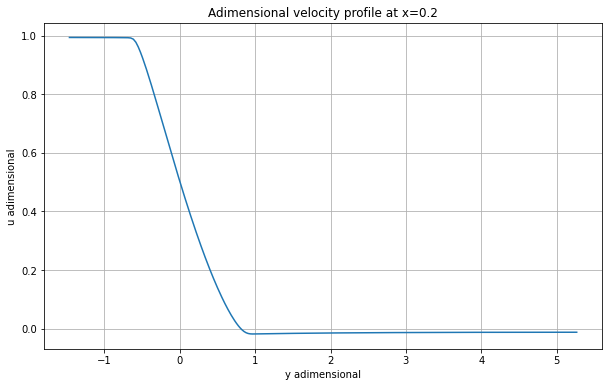

In [76]:
def plot_adimensional(df, x, _U_0 = U_0, _U_1 = U_1):
    # Compute y_star and delta
    y_star = compute_y_star(df, x)
    delta = shear_layer_thickness(df, x)
    print(df)

    df_x = df[df['x'] == x].copy()
    
    # Adimensionalize y and u(y)
    df_x['y_adim'] = (df_x['y'] - y_star) / delta
    df_x['u_adim'] = (df_x['u(y)'] - _U_0) / (_U_1 - _U_0)
    print(df)
    
    # Plot adimensional u(y) vs y
    plt.figure(figsize=(10, 6))
    plt.plot(df_x['y_adim'], df_x['u_adim'])
    plt.xlabel('y adimensional')
    plt.ylabel('u adimensional')
    plt.title(f'Adimensional velocity profile at x={x}')
    plt.grid(True)
    plt.show()

# Test the function
x = 0.2
plot_adimensional(data, x)

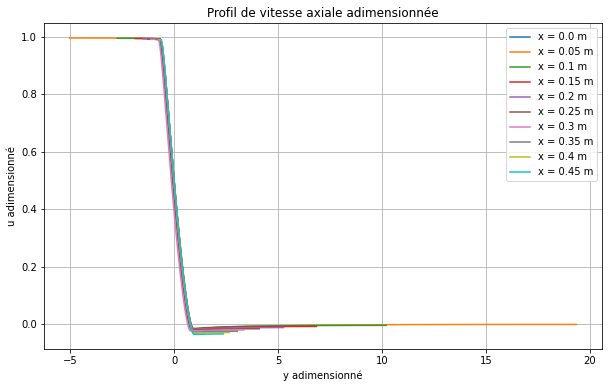

In [77]:
def plot_all_adimensional(df, x_values, _U_0 = U_0, _U_1 = U_1):
    plt.figure(figsize=(10, 6))
    
    for x in x_values:
        # Compute y_star and delta
        y_star = compute_y_star(df, x)
        delta = shear_layer_thickness(df, x)

        df_x = df[df['x'] == x].copy()
        
        # Adimensionalize y and u(y)
        df_x['y_adim'] = (df_x['y'] - y_star) / delta
        df_x['u_adim'] = (df_x['u(y)'] - _U_0) / (_U_1 - _U_0)
        
        # Plot adimensional u(y) vs y with a label
        plt.plot(df_x['y_adim'], df_x['u_adim'], label=f'x = {x} m')
    
    plt.xlabel('y adimensionné')
    plt.ylabel('u adimensionné')
    plt.title('Profil de vitesse axiale adimensionnée')
    #plt.ylim(-2, 2)  # Set the limits of the y-axis
    plt.legend()
    plt.grid(True)
    plt.show()

# Test the function
x_values_coeur = [x for x in x_values if x < 0.462163]
plot_all_adimensional(data, x_values_coeur)

<ipython-input-78-6d35c80329c1>:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap('Reds_r')


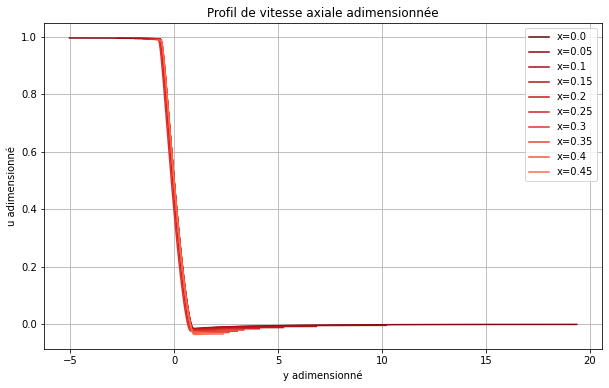

In [78]:
import matplotlib.cm as cm

def plot_all_adimensional(df, x_values, _U_0 = U_0, _U_1 = U_1):
    plt.figure(figsize=(10, 6))
    # Create a reversed colormap
    color_map = cm.get_cmap('Reds_r')
    
    # Normalize x_values to [0, 0.5] for the colormap
    x_values_norm = [x / (2 * max(x_values)) for x in x_values]

    for x, x_norm in zip(x_values, x_values_norm):
        # Compute y_star and delta
        y_star = compute_y_star(df, x)
        delta = shear_layer_thickness(df, x)

        df_x = df[df['x'] == x].copy()
        
        # Adimensionalize y and u(y)
        df_x['y_adim'] = (df_x['y'] - y_star) / delta
        df_x['u_adim'] = (df_x['u(y)'] - _U_0) / (_U_1 - _U_0)
        
        # Plot adimensional u(y) vs y with a label
        plt.plot(df_x['y_adim'], df_x['u_adim'], label=f'x={x}', color=color_map(x_norm))
    
    plt.xlabel('y adimensionné')
    plt.ylabel('u adimensionné')
    plt.title('Profil de vitesse axiale adimensionnée')
    plt.legend()
    plt.grid(True)
    plt.show()

# Test the function
x_values_coeur = [x for x in x_values if x < 0.462163]
plot_all_adimensional(data, x_values_coeur)

Full values: K_0 = 0.07278000727272728, K_1 = 0.0003474863636363643, r^2 = 0.999729907358671


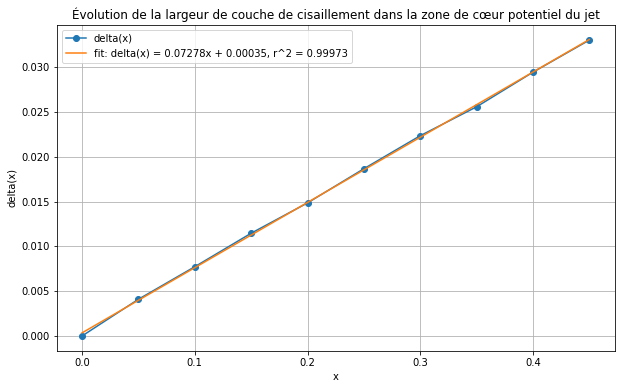

In [79]:
def plot_delta_evolution(df, x_values):
    delta_values = [shear_layer_thickness(df, x) for x in x_values]

    # Perform a linear regression
    K_0, K_1 = np.polyfit(x_values, delta_values, 1)
    
    # Compute the predicted values and the R^2 score
    delta_values_pred = [K_0 * x + K_1 for x in x_values]
    r2 = r2_score(delta_values, delta_values_pred)

    print(f"Full values: K_0 = {K_0}, K_1 = {K_1}, r^2 = {r2}")

    plt.figure(figsize=(10, 6))
    plt.plot(x_values, delta_values, marker='o', linestyle='-', label='delta(x)')
    plt.plot(x_values, delta_values_pred, label=f'fit: delta(x) = {K_0:.5f}x + {K_1:.5f}, r^2 = {r2:.5f}')
    plt.xlabel('x (m)')
    plt.ylabel('delta (m)')
    plt.title('Évolution de la largeur de couche de cisaillement dans la zone de cœur potentiel du jet')
    plt.legend()
    plt.grid(True)
    plt.show()

# Test the function
x_values_coeur = [x for x in x_values if x < 0.462163]
plot_delta_evolution(data, x_values_coeur)

In [80]:
'''def plot_max_difference(df, x_values, _U_0 = U_0, _U_1 = U_1):
    # Create a DataFrame to store the adimensional u(y) values for each x
    df_adim = pd.DataFrame()

    for x in x_values:
        # Compute y_star and delta
        y_star = compute_y_star(df, x)
        delta = shear_layer_thickness(df, x)

        df_x = df[df['x'] == x].copy()
        
        # Adimensionalize y and u(y)
        df_x['y_adim'] = (df_x['y'] - y_star) / delta
        df_x['u_adim'] = (df_x['u(y)'] - _U_0) / (_U_1 - _U_0)
        
        # Add the adimensional u(y) values to df_adim
        df_adim[x] = df_x.set_index('y_adim')['u_adim']

    # Compute the maximum difference at each y_adim
    df_adim['max_diff'] = df_adim.max(axis=1) - df_adim.min(axis=1)

    # Plot the maximum difference vs y_adim
    plt.figure(figsize=(10, 6))
    plt.plot(df_adim.index, df_adim['max_diff'])
    plt.xlabel('y adimensional')
    plt.ylabel('Max difference')
    plt.title('Maximum difference between adimensional velocity profiles')
    plt.grid(True)
    plt.show()

# Test the function
x_values_coeur = [x for x in x_values if x < 0.462163]
plot_max_difference(data, x_values_coeur)'''

"def plot_max_difference(df, x_values, _U_0 = U_0, _U_1 = U_1):\n    # Create a DataFrame to store the adimensional u(y) values for each x\n    df_adim = pd.DataFrame()\n\n    for x in x_values:\n        # Compute y_star and delta\n        y_star = compute_y_star(df, x)\n        delta = shear_layer_thickness(df, x)\n\n        df_x = df[df['x'] == x].copy()\n        \n        # Adimensionalize y and u(y)\n        df_x['y_adim'] = (df_x['y'] - y_star) / delta\n        df_x['u_adim'] = (df_x['u(y)'] - _U_0) / (_U_1 - _U_0)\n        \n        # Add the adimensional u(y) values to df_adim\n        df_adim[x] = df_x.set_index('y_adim')['u_adim']\n\n    # Compute the maximum difference at each y_adim\n    df_adim['max_diff'] = df_adim.max(axis=1) - df_adim.min(axis=1)\n\n    # Plot the maximum difference vs y_adim\n    plt.figure(figsize=(10, 6))\n    plt.plot(df_adim.index, df_adim['max_diff'])\n    plt.xlabel('y adimensional')\n    plt.ylabel('Max difference')\n    plt.title('Maximum differ